In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
sns.set(style="white", color_codes=True)
import plotly.graph_objects as go
from joblib import parallel_backend
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import precision_score,f1_score

import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool

from wordcloud import WordCloud 
import missingno as msno

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split

In [2]:
data= pd.read_csv("Solar_Energy_Production.csv")
data.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [3]:
data.info


<bound method DataFrame.info of                                   name      id                   address  \
0       Calgary Fire Hall Headquarters  314106             1212 42 AV SE   
1       Calgary Fire Hall Headquarters  314106             1212 42 AV SE   
2       Calgary Fire Hall Headquarters  314106             1212 42 AV SE   
3       Calgary Fire Hall Headquarters  314106             1212 42 AV SE   
4       Calgary Fire Hall Headquarters  314106             1212 42 AV SE   
...                                ...     ...                       ...   
258418  Bearspaw Water Treatment Plant  577650  11444 Bearspaw Dam RD NW   
258419  Bearspaw Water Treatment Plant  577650  11444 Bearspaw Dam RD NW   
258420  Bearspaw Water Treatment Plant  577650  11444 Bearspaw Dam RD NW   
258421  Bearspaw Water Treatment Plant  577650  11444 Bearspaw Dam RD NW   
258422  Bearspaw Water Treatment Plant  577650  11444 Bearspaw Dam RD NW   

                          date      kWh  \
0       2017

In [5]:
installed = data.groupby('name')['installationDate'].unique()
installed = pd.DataFrame(installed).sort_values(by='installationDate')
installed

,installationDate
name,
Southland Leisure Centre,[2015/09/01]
Hillhurst Sunnyside Community Association,[2016/09/25]
Calgary Fire Hall Headquarters,[2016/11/07]
Richmond - Knob Hill Community Hall,[2016/11/21]
Whitehorn Multi-Service Centre,[2016/12/13]
City of Calgary North Corporate Warehouse,[2016/12/21]
Glenmore Water Treatment Plant,[2017/01/11]
CFD Firehall #7,[2017/09/13]
Manchester Building M,[2017/10/23]


In [6]:
counts = data.groupby('name')['kWh'].sum()
totals = pd.DataFrame(counts).sort_values(by='kWh', ascending=False)
totals

,kWh
name,
Bearspaw Water Treatment Plant,3082637.596
Whitehorn Multi-Service Centre,2558802.505
Glenmore Water Treatment Plant,1551177.716
Southland Leisure Centre,1147493.626
City of Calgary North Corporate Warehouse,768964.640
Hillhurst Sunnyside Community Association,186441.264
Manchester Building M,183243.243
CFD Firehall #7,170080.887
Calgary Fire Hall Headquarters,110211.611


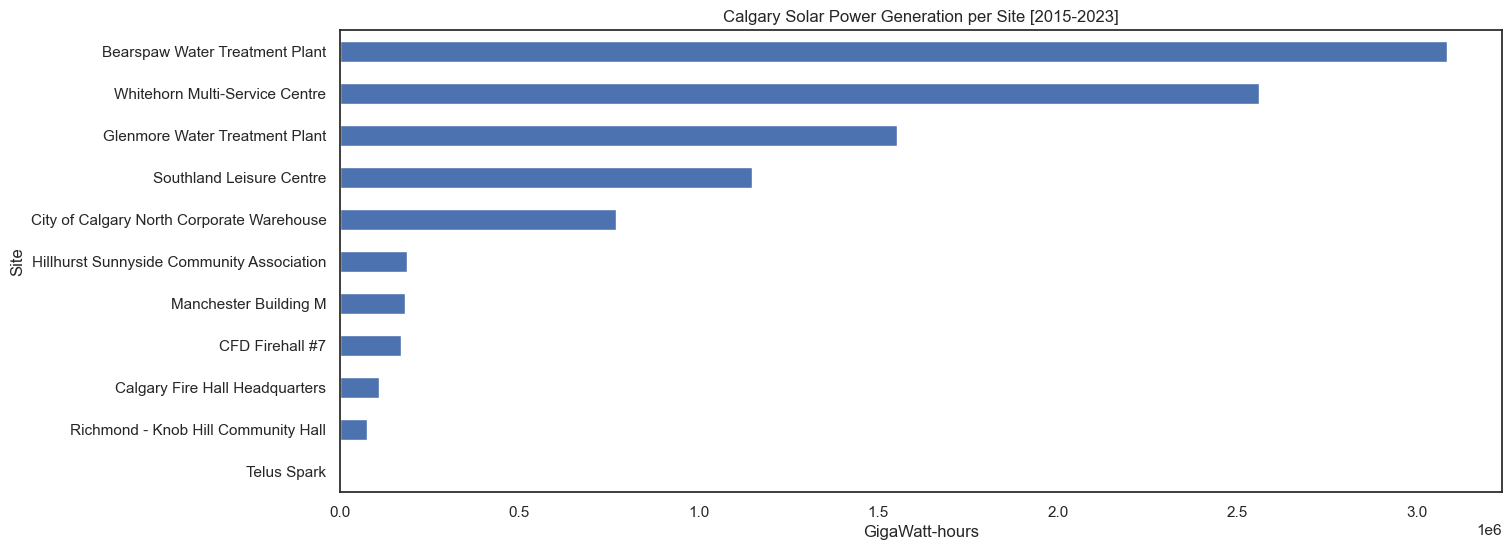

In [8]:
totals = totals.sort_values(by='kWh', ascending=True)

totals.plot(figsize=(15, 6), kind='barh', legend=False)
plt.title('Calgary Solar Power Generation per Site [2015-2023]')
plt.xlabel('GigaWatt-hours')
plt.ylabel('Site')

plt.show()

In [10]:
data_type = data['date'].dtype
print("type:", data_type)

type: object


In [12]:
# create df for time series analysis
data['date'] = pd.to_datetime(data['date']) 

data_pw = data.drop(columns= ['name', 'id', 'address', 'public_url', 'installationDate', 'uid'])
data_pw = data_pw.set_index('date')

data_pw.head()

,kWh
date,
2017-09-11 08:00:00,1.130
2017-09-11 09:00:00,2.340
2017-09-11 10:00:00,3.656
2017-09-11 11:00:00,4.577
2017-09-11 12:00:00,6.506


In [14]:
#change to daily frequency
count_date = data_pw.groupby(data_pw.index.date)['kWh'].sum()

data_clean = pd.DataFrame(count_date)
data_clean['date'] = pd.to_datetime(data_clean.index) 
data_clean = data_clean.set_index('date')

data_clean.head()

,kWh
date,
2015-09-01,286.013
2015-09-02,681.646
2015-09-03,647.906
2015-09-04,102.448
2015-09-05,93.432


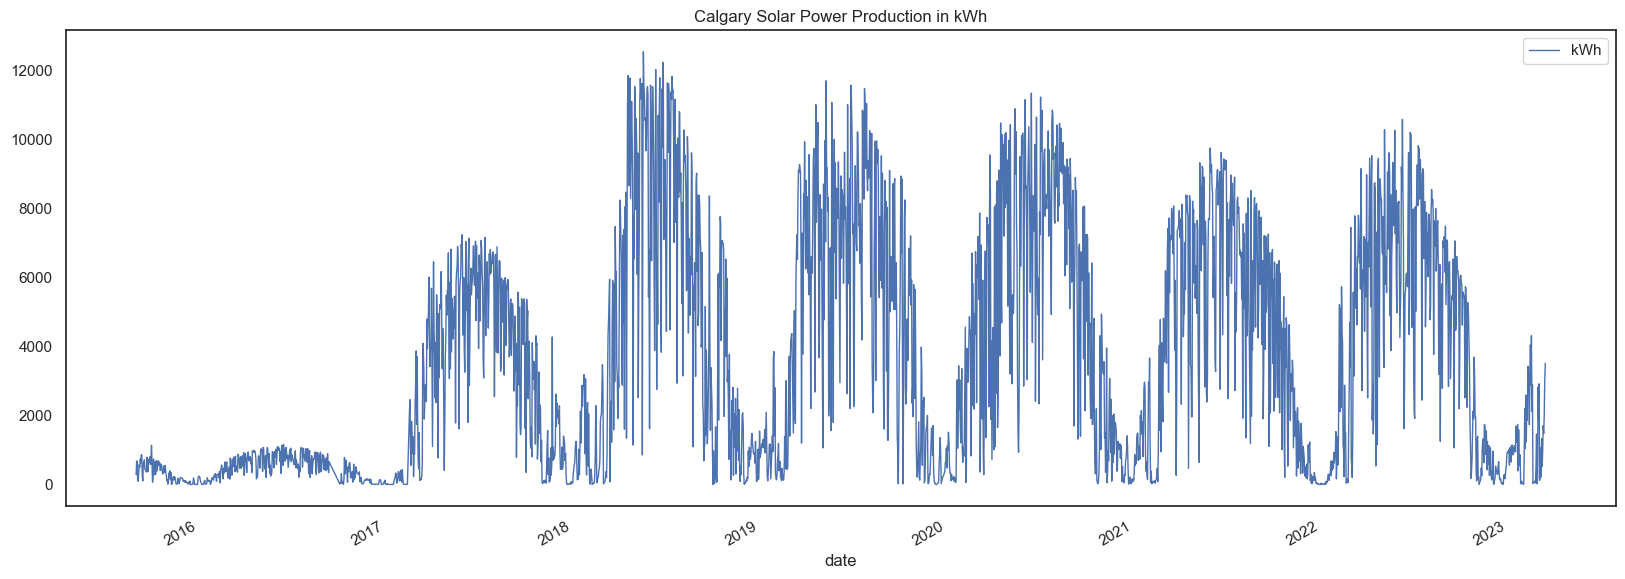

In [15]:
#plot the data
data_clean.plot(style='-', figsize=(20, 7), lw=1,
              title='Calgary Solar Power Production in kWh')
plt.show()

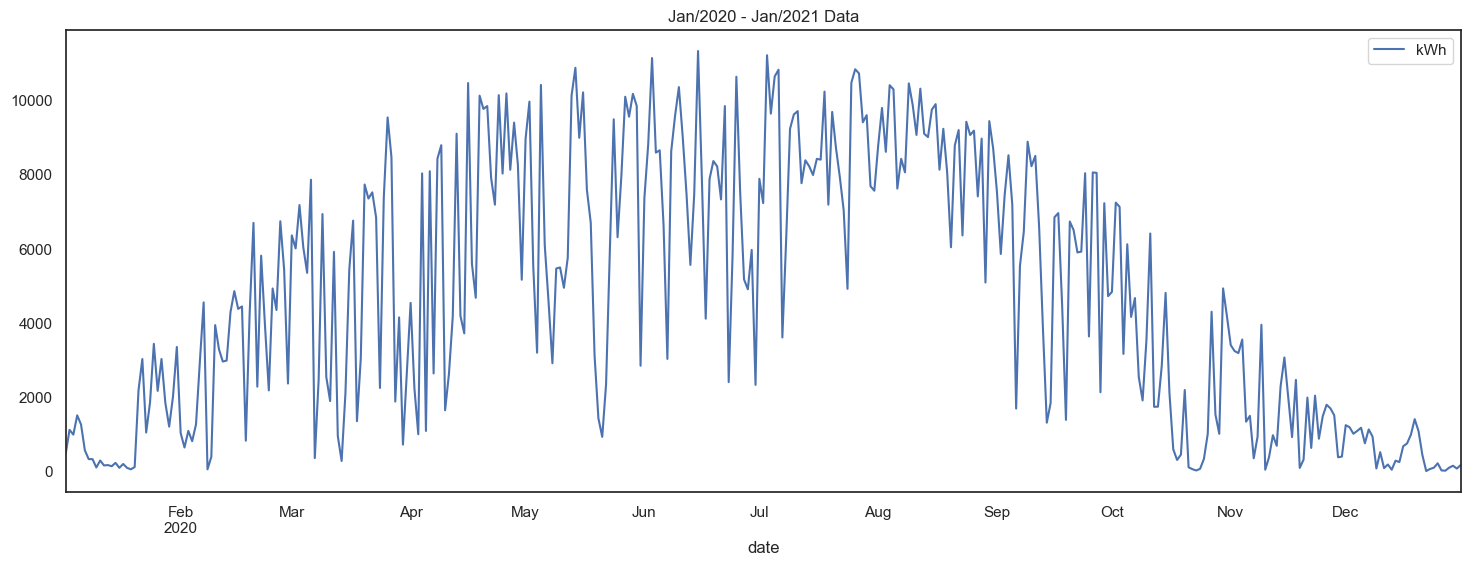

In [16]:
data_clean.loc[(data_clean.index > '2020-01-01') & (data_clean.index < '2021-01-01')] \
    .plot(style='-', figsize=(18, 6), title='Jan/2020 - Jan/2021 Data')
plt.show()

In [23]:
plant_name = "Whitehorn Multi-Service Centre"
frequency = ['h', 'd', 'W', 'M'][2]

plant_data = (data
              .loc[data.name == plant_name, ['date', 'kWh']]
              .set_index('date')
              .resample(frequency).sum()
              .resample(frequency).asfreq().fillna(0)      
        )

plant_data.head()

,kWh
date,
2017-02-19,5224.513
2017-02-26,4250.596
2017-03-05,10467.816
2017-03-12,1188.923
2017-03-19,10532.219


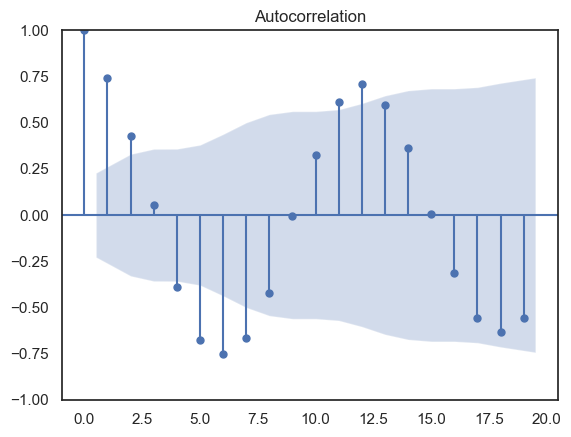

In [26]:
plot_acf(plant_data.resample("M").sum())
plt.show()

In [32]:
year_start = 2017
forecast_horizon = 52
series_data = plant_data.loc[plant_data.index.year >= year_start].kWh
    
train, test = temporal_train_test_split(series_data, test_size=forecast_horizon)

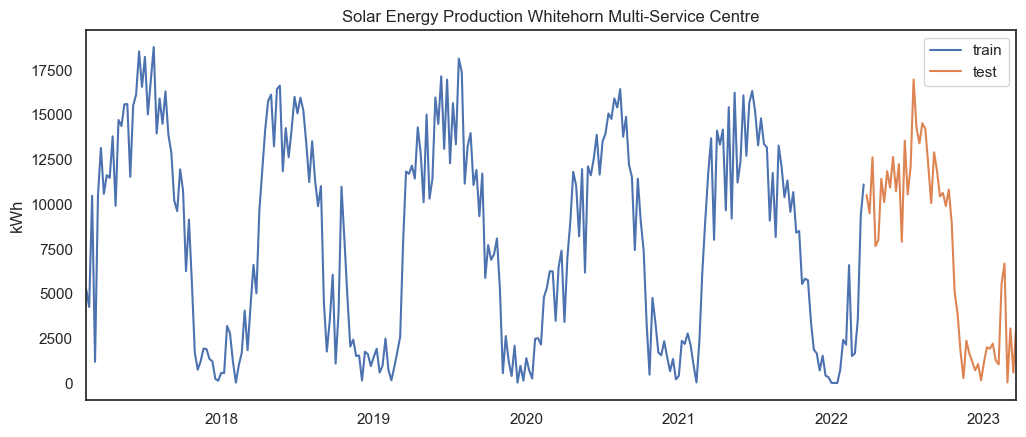

In [33]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.title('Solar Energy Production ' + plant_name)
ax.set(ylabel="kWh")
ax.set_xlabel('')
plt.legend();